In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}",)

Using cpu


/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
df = pd.read_csv('../data/paris_temperature.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(df['datetime'])
temp = df['temp']
temp.head(5)

datetime
2023-10-01    18.9
2023-10-02    20.7
2023-10-03    18.8
2023-10-04    14.2
2023-10-05    14.7
Name: temp, dtype: float64

In [4]:
train = temp[temp.index <= pd.to_datetime('2024/09/15')]
test = temp[temp.index > pd.to_datetime('2024/09/15')]

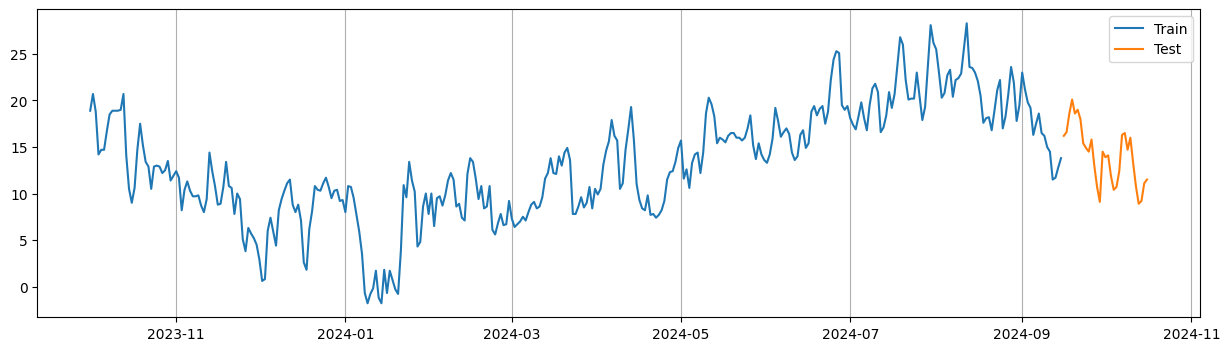

In [5]:
fig = plt.figure(figsize=(15,4))

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.gca().xaxis.grid()
plt.legend()

In [6]:
class ParisTemperatureTimeDelayEmbedding:
    def __init__(self, ts, lags):
        # self.dataset = dataset
        self.ts = ts
        self.lags = lags

    def __getitem__(self, idx: int):
        new_df = pd.DataFrame({'target':self.ts})
        
        for i in range(3):
            shift_temp = self.ts.shift(i+1).rename(f"lag{i+1}")
            new_df = pd.concat([new_df, shift_temp], axis=1)

        new_df = new_df.dropna()

        targets = new_df['target']
        features = new_df.drop('target', axis=1)

        targets = torch.from_numpy(targets.values)
        features = torch.from_numpy(features.values)

        return features[idx, :].to(torch.float), targets[idx].to(torch.float)


    def __len__(self):
        return self.ts.shape[0] - self.lags

In [7]:
lags = 5

train_dataset = ParisTemperatureTimeDelayEmbedding(train, lags=lags)
test_dataset = ParisTemperatureTimeDelayEmbedding(test, lags=lags)

In [8]:
train_dataset[0][0]
test_dataset[0][0]

tensor([18.6000, 16.6000, 16.2000])

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
class MLPBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, x):
        return self.dropout(self.relu(self.linear(x)))


class LstmOneHorizon(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size = 1, hidden_size= 32, num_layers=1, batch_first=True)
        self.mlp_block1 = MLPBlock(32, 16)
        self.regressor = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        _, (x, _) = self.lstm1(x)
        x = self.mlp_block1(x)
        x = self.regressor(x)

        return x.squeeze()


In [11]:
model = LstmOneHorizon().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

----------------------------------------------------------------------------------------------------
EPOCH [1/40]
Loss: 209.4354785572399
Train loss: 209.4354785572399, Validation loss: 192.0285186767578
----------------------------------------------------------------------------------------------------
EPOCH [2/40]
Loss: 198.00779594074595
Train loss: 198.00779594074595, Validation loss: 180.24750518798828
----------------------------------------------------------------------------------------------------
EPOCH [3/40]
Loss: 185.20996323498812
Train loss: 185.20996323498812, Validation loss: 162.14989471435547
----------------------------------------------------------------------------------------------------
EPOCH [4/40]
Loss: 163.73725362257525
Train loss: 163.73725362257525, Validation loss: 136.26672744750977
----------------------------------------------------------------------------------------------------
EPOCH [5/40]
Loss: 139.85349022258413
Train loss: 139.85349022258413, Vali

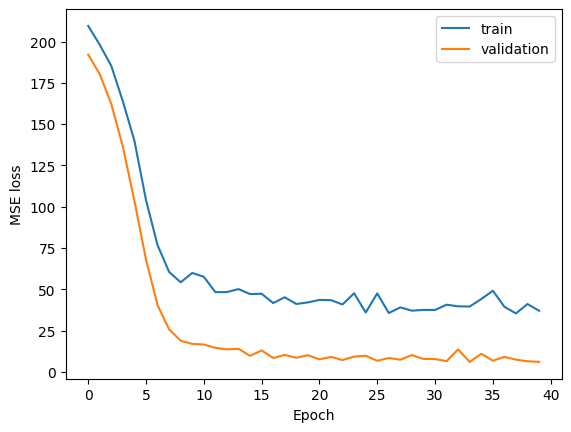

In [12]:
epochs = 40
train_loss = []
val_loss = []
train_rmse = []
val_rmse = []
best_val_loss = 10000


for epoch in range(epochs):
    print('-' * 100)
    print(f'EPOCH [{epoch+1}/{epochs}]')


    model.train()
    loss_train_batch = 0 
    for i, (features, target) in enumerate(train_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(features)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_train_batch += loss.item()
    
    train_loss.append(loss_train_batch/len(train_dataloader))
    print(f'Loss: {loss_train_batch/len(train_dataloader)}')


    model.eval()
    loss_val_batch = 0
    with torch.no_grad():
        for i, (features, target) in enumerate(test_dataloader):
            features = features.to(device).unsqueeze(2)
            target = target.to(device)

            output = model(features)
            vloss = loss_fn(output, target)

            loss_val_batch += vloss.item()

    val_loss.append(loss_val_batch/len(test_dataloader))
    print(f'Train loss: {loss_train_batch/len(train_dataloader)}, Validation loss: {loss_val_batch/len(test_dataloader)}')

    if (loss_val_batch < best_val_loss):
        best_val_loss = loss_val_batch
        torch.save(model.state_dict(), '../model/lstm_ts5_b16.pth')


plt.plot(np.arange(len(train_loss), dtype=int), train_loss, label='train')
plt.plot(np.arange(len(val_loss), dtype=int), val_loss, label= 'validation')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()



/tmp/ipykernel_47419/316466918.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load('../model/lstm_ts5_b16.pth'))


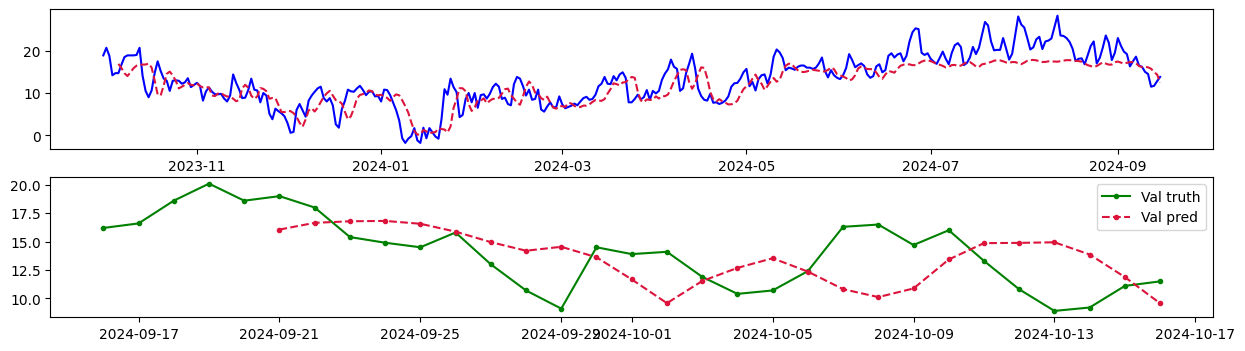

In [30]:
test_model = LstmOneHorizon()
test_model.load_state_dict(torch.load('../model/lstm_ts5_b16.pth'))

train_outputs = []
val_outputs = []
test_model.eval()
with torch.no_grad():
    for i, (features, target) in enumerate(train_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        output = test_model(features).cpu().tolist()
        train_outputs += output

    for i, (features, target) in enumerate(test_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        output = test_model(features).cpu().tolist()
        val_outputs += output

fig = plt.figure(figsize=(15,4))

fig.add_subplot(2,1,1)
plt.plot(train, label='Train truth', color='blue')
plt.plot(train.index[lags:], train_outputs,color='crimson', linestyle = 'dashed', label='Train pred')


fig.add_subplot(2,1,2)
plt.plot(test, color='green', label='Val truth', marker='.')
plt.plot(test.index[lags:], val_outputs,color = 'crimson', linestyle = 'dashed',marker='.', label='Val pred')

plt.legend()
